In [1]:
#Script per modificare il catalogo GLADE_2.4 cambiandone i valori. 
#------------------Import--------------------------------

import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

from astropy.cosmology import Planck15
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.table import Table

from multiprocessing import Pool
import os 
import statistics as stat
import time
from tqdm import tqdm

In [2]:
#Catalogue path
cat_data_path='/home/rciancarella/DarkSirensStat/data/GLADE/'
os.chdir(cat_data_path)
#all_event=os.listdir()
#print(all_event)

In [3]:
H0GLOB= 67#67.9 #69
Om0GLOB=0.319
Xi0Glob =1.
cosmoglob = Planck15
clight = 2.99792458* 10**5#km/s
cosmofast = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)
import random as rn
clight = 2.99792458* 10**5#km/s


#---------------Def Funzioni---------------------
def reflag(dataframe, flag_value, trim_factor):
    newdf=dataframe
    print('setting flag error to {} on glaxies, trimming the number by a factor {}'.format(flag_value, trim_factor))
    nrows=int(newdf.shape[0]/trim_factor)
    print('nrows={}, initial rows={}'.format(nrows,newdf.shape[0]))
    if trim_factor!=1:
        newdf=newdf.sample(nrows)
        print('trimmato')
    newdf['lum_dist_flag']=newdf['lum_dist_flag'].replace(to_replace=2,value=flag_value)
    newdf['lum_dist_flag']=newdf['lum_dist_flag'].replace(to_replace=1,value=flag_value)
    if flag_value==4:
        newdf['lum_dist_flag']=newdf['lum_dist_flag'].replace(to_replace=1,value=flag_value)
        newdf['lum_dist_flag']=newdf['lum_dist_flag'].replace(to_replace=2,value=flag_value)
        newdf['lum_dist_flag']=newdf['lum_dist_flag'].replace(to_replace=3,value=flag_value)
        filename=os.path.join(os.getcwd(), 'GLADE_spectro_flag4'+'_'+str(trim_factor)+'.txt')
    else:
        filename=os.path.join(os.getcwd(), 'GLADE_spectro'+'_'+str(trim_factor)+'.txt')
    print('\nsalvataggio del nuovo catalogo, attendere')
    np.savetxt(filename,newdf.values,fmt='%s')
    print('{} salvato'.format(filename))
    
def cont_flag3(dataframe):
    start=dataframe.shape[0]
    flag3=dataframe.apply(lambda x: True if x['lum_dist_flag'] == 3 else False , axis=1)
    nflag=len(flag3[flag3 == True].index)
    perc=nflag*100/start
    print('Initial hosts={}, number of flag3 host={} that is {}%'.format(start,nflag,perc))
    
def cont_flag2(dataframe):
    start=dataframe.shape[0]
    flag2=dataframe.apply(lambda x: True if x['lum_dist_flag'] == 2 else False , axis=1)
    nflag=len(flag2[flag2 == True].index)
    perc=nflag*100/start
    print('Initial hosts={}, number of flag2 host={} that is {}%'.format(start,nflag,perc))
    
def trimmer(dataframe,trim_factor):
    newdf=dataframe
    print('trimming the catalogue by {} %'.format(trim_factor))
    nrows=int(newdf.shape[0]*(1-trim_factor/100))
    print('nrows={}, initial rows={}'.format(nrows,newdf.shape[0]))
    if trim_factor!=0:
        newdf=newdf.sample(nrows)
        print('trimming')
        filename=os.path.join(os.getcwd(), 'GLADE_trimmed'+'_'+str(trim_factor)+'.txt')
        print('\nsalvataggio del nuovo catalogo, attendere')
        np.savetxt(filename,newdf.values,fmt='%s')
        print('{} salvato'.format(filename))
    

def fake_host(df,ra,dec,dl,z):
    newrow=puppetrow
    newrow['right_ascension_degrees']=ra
    newrow['declination_degrees']=dec
    newrow['dl']=dl
    newrow['app_K_mag']=8
    newrow['pec_vel_correction']=1
    #newrow['err_lum_dist']='NaN'
    newrow['z']=z
    return newrow
def random_displace(ra,dec,dl,delta):
    raout=ra+rn.uniform(-1,1)
    decout=dec+rn.uniform(-1,1)
    dlout=rn.gauss(dl,delta)
    zout=Planck15.H(0).value*dlout/clight
    return raout, decout, dlout, zout
    
    

    
    

In [ ]:
#--------------globals and flags-----------------
nohost=8
clear=1
onebyone=1
#---------------Main-----------------------------
#alcuni appunti sui flag:

#Object type flag: Q the source is from the SDSS-DR12Q catalogue. C: the source is a globular cluster. 
#G:the source is not from the SDSS-DR12Q catalogue and notidentified as a globular cluster

#Luminosity distance measurement flag. 0: the object has neither measured distance nor measured redshift value.
#1: the object has measured redshift value from which we have calculated its distance. 2: the object has measured distance
#value from which we have calculated its redshift. 3: we have replaced the measured photometric redshift with spectroscopic
#redshift from the 2MASS Redshift Survey catalogue,from which we have calculated its distance.

#Velocity correction flag. It indicates whether the peculiar velocity correction was not (’0’) or was (’1’) applied
#when the distance of the object was calculated.

#df = pd.read_csv('TestGLADE.txt', sep=" ", header=None, low_memory=False)
tempdf = pd.read_csv('puppet.txt', sep=" ", header=None, low_memory=False)
df = pd.read_csv('GLADE_2.4.txt', sep=" ", header=None, low_memory=False)
#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
df.columns=colnames
tempdf.columns=colnames
puppetrow=tempdf.iloc[0]
ncols=len(df.columns)
nraws=len(df.index)
print("righe={}, colonne={}, shape={} " .format(nraws,ncols,df.shape))

#conteggio eventi tra z1 e z2
#print(df.shape[0])
#z1=0.05
#z2=0.12
#err=0.02
#counterdf=df[df['z'].between(z1-err, z1+err)]
#print(counterdf.shape[0])
#newconter=df[df['z'].between(z2-err, z2+err)]
#print(newconter.shape[0])
#print(len(newconter))


In [ ]:

znull=np.where(df.z.notna(),1,0)
dlnull=np.where(df.dl.notna(),1,0)
z_zero=np.count_nonzero(znull==0)
dl_zero=np.count_nonzero(dlnull==0)
print('la colonna z ha {} elementi nulli\nla colonna dl ha {} elementi nulli'.format(z_zero,dl_zero))
dLvals = df[df.dl.notna()]['dl']
print('%s elementi in dLvals'%dLvals.shape[0])
zvals = df[df.z.notna()]['z']
print('%s elementi in z'%zvals.shape[0])


newdf=df[df['z'].notna()]
newdf=newdf[newdf['dl'].notna()]
znull=np.where(newdf.z.notna(),1,0)
dlnull=np.where(newdf.dl.notna(),1,0)
z_zero=np.count_nonzero(znull==0)
dl_zero=np.count_nonzero(dlnull==0)
col=newdf['z']
max_z=col.max()
print('massimo valore redshift: z={}  '.format(max_z))

print('la colonna z ha {} elementi nulli\nla colonna dl ha {} elementi nulli'.format(z_zero,dl_zero))
#print('\n\n\n salvataggio del nuovo catalogo, attendere')
#np.savetxt('GLADE_nonull.txt',newdf.values,fmt='%s')
#print('GLADE_nonull.txt salvato')
    
    


In [ ]:
#reflag(newdf,3,1)

In [ ]:
#cont_flag3(newdf)

In [ ]:
#cont_flag2(newdf)

In [ ]:
#trimmer(newdf,90)

In [ ]:
#-------------Inserimento Fake Hosts--------------------------
#fake_host(df,ra,dec,dl,z)
iteration=10
#----------------GW190412-----------------------
ra=218.4521484375
dec=36.42357364233115
dl=734.121575455142
std=93.28161482151035
z=0.16587940821823915
toadd=fake_host(newdf,ra,dec,dl,z)
newdf=newdf.append(toadd)
#for i in range(iteration):
    #ra0,dec0,dl0,z0 = random_displace(ra,dec,dl,std)
    #toadd=fake_host(newdf,ra0,dec0,dl0,z0)
    #newdf=newdf.append(toadd)
print('1 of 5 done')
#-------------GW190814---------------------------
ra=12.7001953125
dec=-24.87076339473571
dl=240.7344958889034
std=26.05124052395576
z=0.05439548032764159
toadd=fake_host(newdf,ra,dec,dl,z)
newdf=newdf.append(toadd)
#for i in range(iteration):
    #ra0,dec0,dl0,z0 = random_displace(ra,dec,dl,std)
    #toadd=fake_host(newdf,ra0,dec0,dl0,z0)
    #newdf=newdf.append(toadd)
print('2 of 5 done')
#---------------GW190924_021846---------------------
ra=127.265625
dec=16.25709623792208
dl=572.3830413569922 
std=136.682093600127
z=0.1293335645605956
toadd=fake_host(newdf,ra,dec,dl,z)
newdf=newdf.append(toadd)
for i in range(iteration):
    ra0,dec0,dl0,z0 = random_displace(ra,dec,dl,std)
    toadd=fake_host(newdf,ra0,dec0,dl0,z0)
    newdf=newdf.append(toadd)
print('3 of 5 done')    
#-----------------GW190527_092055--------------------------
ra=39.14383561643836
dec=-63.07261938698223
dl=3562.931275516
std=1965.511983689016
z=0.8050668326134269
toadd=fake_host(newdf,ra,dec,dl,z)
#newdf=newdf.append(toadd)
#for i in range(iteration):
    #ra0,dec0,dl0,z0 = random_displace(ra,dec,dl,std)
    #toadd=fake_host(newdf,ra0,dec0,dl0,z0)
    #newdf=newdf.append(toadd)
print('4 of 5 done')

#-----------------GW170817--------------------------
#ra=196.03586373589667 #3.44616 #105.29296875
#dec=-20.841149792255525#-0.408084 #-0.7833651412800737
#dl=34.03408225450563
#std=7.499686641911211
#z=0.0087
#toadd=fake_host(newdf,ra,dec,dl,z)
#newdf=newdf.append(toadd)
#for i in range(iteration):
    #ra0,dec0,dl0,z0 = random_displace(ra,dec,dl,std)
    #toadd=fake_host(newdf,ra0,dec0,dl0,z0)
    #newdf=newdf.append(toadd)
print('5 of 5 done')
#------------------Fake-BS-------------------------
ra=196.03586373589667 #3.44616 #105.29296875
dec=-20.841149792255525#-0.408084 #-0.7833651412800737
dl=20
std=4.595980697842096
z=cosmoglob.H(0).value*dl/clight
toadd=fake_host(newdf,ra,dec,dl,z)
newdf=newdf.append(toadd)
newdf=newdf.tail(6)
#----------------Saving-------------------------------
filename=os.path.join(os.getcwd(), 'GLADE_fakeBS20'+'.txt')
print('Saving new catalogue with host injection, wait...')
np.savetxt(filename,newdf.values,fmt='%s')
print('{} saved!'.format(filename))


# From FlagShip to GLADE-like

In [ ]:
#------------read the flagship-------------------------------------
dat = Table.read('11536.fits', format='fits')
flagship = dat.to_pandas()#all good, is an only text fits
print(flagship.columns)
flagship.head(3)

In [ ]:
#alcuni appunti sui flag:

#Object type flag: Q the source is from the SDSS-DR12Q catalogue.
#C: the source is a globular cluster. 
#G:the source is not from the SDSS-DR12Q catalogue and notidentified as a globular cluster

#Luminosity distance measurement flag.
#0: the object has neither measured distance nor measured redshift value.
#1: the object has measured redshift value from which we have calculated its distance. 
#2: the object has measured distance value from which we have calculated its redshift. 
#3: we have replaced the measured photometric redshift with spectroscopic redshift 
#from the 2MASS Redshift Survey catalogue,from which we have calculated its distance.

#Velocity correction flag. It indicates whether the peculiar velocity correction was not (’0’)
#or was (’1’) applied when the distance of the object was calculated.


In [6]:
#---------------read Glade-------------------
glade = pd.read_csv('GLADE_2.4.txt', sep=" ", header=None, low_memory=False)
#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
glade.columns=colnames
glade.head(5)
klum=np.array(glade['app_K_mag'])
#zglade=np.array(flagship['true_redshift_gal'])

In [ ]:
ramin=np.array(flagship['ra_gal']).min()
print(ramin)
ramax=np.array(flagship['ra_gal']).max()
print(ramax)

In [ ]:
decmin=np.array(flagship['dec_gal']).min()
print(decmin)
decmax=np.array(flagship['dec_gal']).max()
print(decmax)

In [7]:
mean_app_B_mag=np.sum(glade['app_B_mag'])/glade.shape[0]
mean_abs_B_mag=np.sum(glade['abs_B_mag'])/glade.shape[0]
mean_app_J_mag=np.sum(glade['app_J_mag'])/glade.shape[0]
mean_app_H_mag=np.sum(glade['app_H_mag'])/glade.shape[0]
mean_app_K_mag=np.sum(glade['app_K_mag'])/glade.shape[0]
print(mean_app_B_mag,mean_abs_B_mag,mean_app_J_mag,mean_app_H_mag,mean_app_K_mag)

10.535271935685417 inf 5.277627146516081 4.923685721873297 4.862867403148511


lum mean=13.334410160003385, lum std=0.7488173704298869


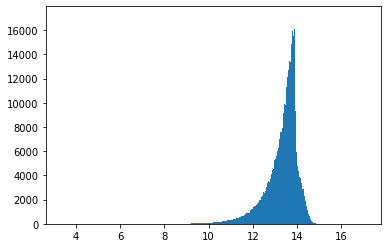

In [8]:
klum = klum[~np.isnan(klum)]
plt.hist(klum,bins='auto')
klum_mean=stat.mean(klum)
klum_std=stat.stdev(klum)
print('lum mean={}, lum std={}'.format(klum_mean,klum_std))

In [ ]:
scatter_k=np.array(glade['app_K_mag'])
scatter_z=np.array(glade['z'])


In [9]:
err_app_B_mag=np.sum(glade['err_app_B_mag'])/glade.shape[0]
err_app_J_mag=np.sum(glade['err_app_J_mag'])/glade.shape[0]
err_app_H_mag=np.sum(glade['err_app_H_mag'])/glade.shape[0]
err_app_K_mag=np.sum(glade['err_app_K_mag'])/glade.shape[0]
print(err_app_B_mag,err_app_J_mag,err_app_H_mag,err_app_K_mag)

0.12391253898540787 0.029373865791390466 0.033138621476712704 0.04406159611796981


In [ ]:
h=0.67
mynumevent=int(43495)
myngcup=int(4736)
GWGC_name='NGC'+ str(myngcup)
HyperLEDA_name=GWGC_name
MASS_XSC_name='NaN'
type_flag='G'
proxy_row={'numevent':mynumevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
           '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
           'right_ascension_degrees':0,'declination_degrees':0,'dl':0,'z':0,
           'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
           'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
           'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
           'app_K_mag':klum_mean+4,'err_app_K_mag':klum_std,
           'lum_dist_flag':3,'pec_vel_correction':0
          }

In [ ]:

#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
glade_like = pd.DataFrame(columns=colnames)
#glade_like.columns=colnames
glade_like.head()

In [ ]:
#-----------filler-------------------
def GLADE_inator(iterations):
#for i in tqdm(range(flagship.shape[0])):
#for i in range(iterations):
    i=iterations
    numevent=mynumevent+i
    ngcup=myngcup+i
    GWGC_name='NGC'+ str(ngcup)
    HyperLEDA_name=GWGC_name
    ra_gal=flagship['ra_gal'][i]
    dec_gal=flagship['dec_gal'][i]
    zz=flagship['true_redshift_gal'][i]
    #----------dl----------------------
    #distances are in Mpc/h and are comoving distances. We need luminosity distances and Mpc 
    host_x=flagship['x_gal'][i]/h #restore the right units
    host_y=flagship['y_gal'][i]/h
    host_z=flagship['z_gal'][i]/h

    lum_host_x=host_x*(1+zz)
    lum_host_y=host_y*(1+zz)
    lum_host_z=host_z*(1+zz)
    dl=np.sqrt(lum_host_x**2+lum_host_y**2+lum_host_z**2)
    temp_k_lum=np.random.normal(loc=klum_mean,scale=2*klum_std)
    #----------row to append---------------------
    proxy_row={'numevent':numevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
           '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
           'right_ascension_degrees':ra_gal,'declination_degrees':dec_gal,'dl':dl,'z':zz,
           'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
           'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
           'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
           'app_K_mag':temp_k_lum,'err_app_K_mag':klum_std,
           'lum_dist_flag':3,'pec_vel_correction':0
          }
    #data.append([proxy_row])
    return proxy_row
    #print(proxy_row)
#glade_like.head()

In [ ]:
arr=np.arange(0,flagship.shape[0],dtype=int)
data=[]
tmp=[]
start_time = time.time()
with Pool(13) as p:
    tmp=p.map(GLADE_inator, arr)
print("--- %s seconds ---" % (time.time() - start_time))
#glade_like.to_csv(r'GLADE_flagship.txt', header=None, index=None, sep=' ', mode='a')

In [ ]:
glade_like=glade_like.append(tmp, ignore_index=True)
glade_like.head()

In [ ]:
glade_like.to_csv('GLADE_flagship.txt', header=None, index=None, sep=' ')

In [ ]:
del tmp
del data

In [ ]:
proxy_row2={'numevent':7,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
           '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
           'right_ascension_degrees':0,'declination_degrees':0,'dl':0,'z':0,
           'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
           'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
           'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
           'app_K_mag':temp_k_lum,'err_app_K_mag':klum_std,
           'lum_dist_flag':3,'pec_vel_correction':0
          }

In [ ]:
tmp

In [ ]:
glade_like=glade_like.append(tmp, ignore_index=True)
glade_like.head()

In [ ]:
base=[]
base.append([proxy_row,proxy_row2])
print(base)

In [ ]:
print(glade_like['right_ascension_degrees'].min())
print(glade_like['right_ascension_degrees'].max())
print(glade_like['declination_degrees'].min())
print(glade_like['declination_degrees'].max())

# Add host to FlaghShip

In [4]:
#myglade = pd.read_csv('GLADE_flagship.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
myglade = pd.DataFrame(columns = colnames)
#myglade.columns=colnames
myglade.head(5)

,numevent,GWGC_name,HyperLEDA_name,2MASS_XSC_name,SDSS-DR12Q_name,type_flag,right_ascension_degrees,declination_degrees,dl,err_lum_dist,...,err_app_B_mag,abs_B_mag,app_J_mag,err_app_J_mag,app_H_mag,err_app_H_mag,app_K_mag,err_app_K_mag,lum_dist_flag,pec_vel_correction


In [ ]:
myglade=myglade.query('1.4< z & z > 1.8')

In [ ]:
myglade.shape[0]

In [ ]:
tempdf=myglade

In [ ]:
myglade=tempdf.query('35< declination_degrees & declination_degrees >75')
#myglade=myglade.query('15< right_ascension_degrees & right_ascension_degrees > 65')

In [ ]:
myglade.shape[0]

In [ ]:
exist= 1.5 in myglade.z
print (exist)

In [10]:
mynumevent=int(14091027)
myngcup=int(14052268)
GWGC_name='NGC'+ str(myngcup)
HyperLEDA_name=GWGC_name
MASS_XSC_name='NaN'
type_flag='G'
numevent=mynumevent+1
ngcup=myngcup+1
GWGC_name='NGC'+ str(ngcup)
HyperLEDA_name=GWGC_name
ra_gal=22.546875
dec_gal=44.993880150457116
zz=1.7
#----------dl----------------------
dl=13102.8222124438
temp_k_lum=np.random.normal(loc=klum_mean,scale=2*klum_std)
#----------row to append---------------------
proxy_row={'numevent':numevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
       '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
       'right_ascension_degrees':ra_gal,'declination_degrees':dec_gal,'dl':dl,'z':zz,
       'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
       'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
       'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
       'app_K_mag':14,'err_app_K_mag':0,
       'lum_dist_flag':3,'pec_vel_correction':0
      }

In [11]:
hostedglade=myglade.append(proxy_row, ignore_index=True)

In [12]:
mynumevent=int(14091028)
myngcup=int(14052269)
GWGC_name='NGC'+ str(myngcup)
HyperLEDA_name=GWGC_name
MASS_XSC_name='NaN'
type_flag='G'
numevent=mynumevent+1
ngcup=myngcup+1
GWGC_name='NGC'+ str(ngcup)
HyperLEDA_name=GWGC_name
ra_gal=59.9768875192604
dec_gal=60.008985691511455
zz=1.499999
#----------dl----------------------
dl=11239.437561544408
temp_k_lum=np.random.normal(loc=klum_mean,scale=2*klum_std)
#----------row to append---------------------
proxy_row={'numevent':numevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
       '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
       'right_ascension_degrees':ra_gal,'declination_degrees':dec_gal,'dl':dl,'z':zz,
       'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
       'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
       'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
       'app_K_mag':14,'err_app_K_mag':0,
       'lum_dist_flag':3,'pec_vel_correction':0
      }

In [13]:
hostedglade=hostedglade.append(proxy_row, ignore_index=True)

In [14]:
hostedglade.to_csv('GLADE_flagship_two_host_alone_nofodder.txt', header=None, index=None, sep=' ')